# ROIs corresponding to dose volumes

This notebook demonstrates how to create Scikit-rt ROI object corresponding to volume receiving a specified dose.  It uses the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)<br/>
https://doi.org/10.6084/m9.figshare.12579707.v1

**Note:** If not already present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` in the
first code cell below.  The download file has a size of 1.6 GB, so download may
take a while.

## Module import and data download

The following imports modules needed for this demo, defines the path
to the data directory, and downloads the demo dataset if not already present, and sets some viewer options.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from skrt import Patient, set_viewer_options, ROI, StructureSet
from skrt.core import download
from skrt.dose import sum_doses

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)
    
# Set Matplotlib runtime configuration (optional).
set_viewer_options()

# Indicate whether to show user interface for image viewer.
no_ui = False

## Reading patient data

The following demonstrates creation of a sorted list of paths to patient folders, reading of the data for a single [Patient](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Patient), and identification of the [Study](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Study) containing data of interest here: CT image and dose from radiotherapy planning.

In [2]:
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))

# Define index for path to patient folder of interest.
idx = 0

# Read patient data.
patient = Patient(paths[idx], unsorted_dicom=True)

# Identify study containing ct_image, ct_structure_set, ct_dose.
# If no study contains all of these data types,
# an exception will be raised.
for study in patient.studies + [None]:
    if all(["ct" in getattr(study, f"{dtype}_types", [])
            for dtype in ["image", "dose"]]):
        break

if study is None:
    raise RuntimeError("No study found with required data types")

## Obtaining references to CT image and dose

The following demonstrates how to obtain references to data objects.  Printing an object will list the object's attributes, and their values.

In [3]:
# Obtain reference to earliest CT image. 
im = study.ct_images[0]

# Obtain sum of image-associated doses.
dose = sum_doses(im.doses)

# Ensure that the dose array has the same geometry as the image array.
dose.match_size(im)
dose.image = im

## Creating and plotting ROIs corresponding to dose volumes

The following demonstrates creation of ROIs corresponding to volumes receiving specified doses, creation of a StructureSet from these ROIs.

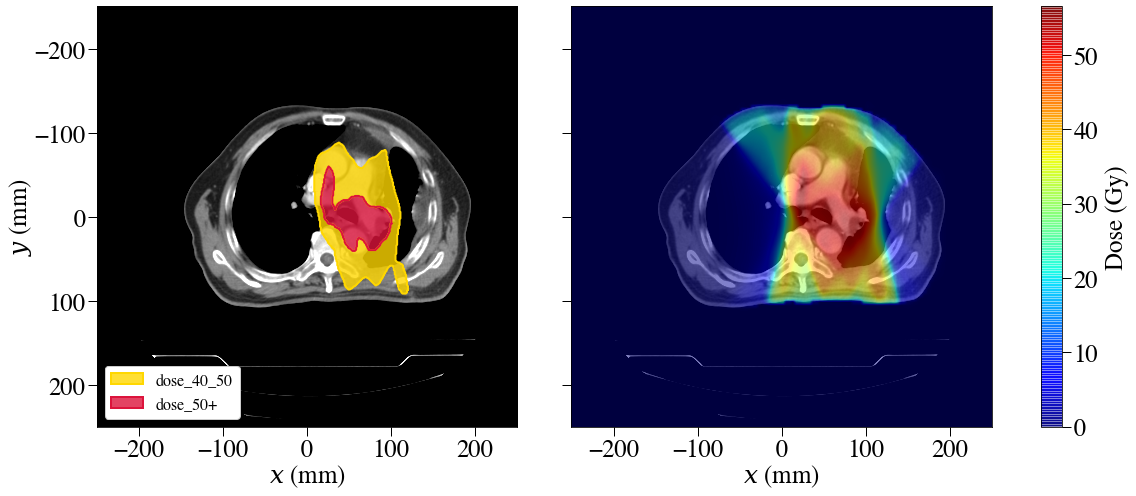

In [4]:
# Create ROI corresponding to dose between 40 Gy and 50 Gy.
dose_40_50 = ROI(dose.get_intensity_mask(40, 50), color="gold", name="dose_40_50")

# Create ROI corresponding to dose greater than 50 Gy.
dose_50 = ROI(dose.get_intensity_mask(50), color="crimson", name="dose_50+")

# Create StructureSet object.
ss = StructureSet([dose_40_50, dose_50], name="dose_volumes")

# Display images with (left) dose ROIs and (right) dose overain.
im.view(images=im, dose=[None, dose], rois=ss, roi_plot_type="filled",
        roi_opacity=0.8, legend=True, colorbar=-1, figsize=(18, 7), no_ui=no_ui);